# Dialogue summarization using the pre-trained Pegasus model and fine tuning with the SAMSum dataset.

Importing basic libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:200"

1. Importing the Hugging Face Transformers library along with support for the SentencePiece tokenizer.
2. Installing the Hugging Face Datasets library.
3. Installing the 'sacrebleu' library, which is a popular tool for calculating BLEU scores.
4. Installing the 'rouge_score' library, which provides tools for calculating ROUGE scores.
5. Installing the py7zr library, which is a Python library for working with 7z archives. 7z is a file compression format similar to zip or tar.

**Note:** The -q flag at the end of the command makes the installation process quiet, suppressing unnecessary output.

In [ ]:
!pip install transformers==4.28.0 sentencepiece torch -q
!pip install datasets sacrebleu rouge_score py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.1 MB/s eta 0:

Displaying information about NVIDIA GPU usage in environments

In [ ]:
!nvidia-smi

Sat Aug 19 17:55:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#  Importing torch library for working with PyTorch-based operations in the code.
import torch

Checking if the cuda is available or not.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using device:', device)

Using device: cuda


Installing Weights and Biases for experiment tracking:

In [ ]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import os

os.environ["WANDB_PROJECT"] = "exprmt"
os.environ["WANDB_LOG_MODEL"] = "true"

In [ ]:
# Importing the Hugging Face pipeline and set_seed functions for easy model usage and reproducibility.
from transformers import pipeline, set_seed

# Importing the load_dataset and load_metric functions from the Hugging Face datasets library to load datasets and evaluation metrics.
from datasets import load_dataset, load_metric

# Importing the AutoModelForSeq2SeqLM and AutoTokenizer classes from the Hugging Face transformers library for working with sequence-to-sequence language models.
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Importing the tqdm library for displaying progress bars during iterations.
from tqdm import tqdm



In [ ]:
# Importing classes from the Hugging Face transformers library for sequence-to-sequence language models and their tokenizers.
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

Use this code below when you want to use the pre-tranined model importing from the Hugging face.

In [ ]:
model_ckpt = "google/pegasus-cnn_dailymail"

# Initializing a tokenizer using a pre-trained model checkpoint.
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Creating an instance of the AutoModelForSeq2SeqLM class, initialized with a pre-trained model checkpoint specified by model_ckpt, and moving the model to the specified GPU using .to(device).
model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [ ]:
dataset_samsum = load_dataset('samsum')

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
dataset_samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
# Calculating the lengths of each split in the 'samsum' dataset and storing the results in the list split_lengths.
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

In [ ]:
split_lengths

[14732, 819, 818]

In [ ]:
 print(f"Features: {dataset_samsum['train'].column_names}")

Features: ['id', 'dialogue', 'summary']


In [ ]:
print("\nDialogue:")

print(dataset_samsum["test"][1]["dialogue"])

print("\nSummary:")

print(dataset_samsum["test"][1]["summary"])


Dialogue:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary:
Eric and Rob are going to watch a stand-up on youtube.


In [ ]:
# Get all named parameters and their count
named_params = list(model_pegasus.named_parameters())
total_params = sum(p.numel() for p in model_pegasus.parameters())

In [ ]:
named_params

[('model.shared.weight',
  Parameter containing:
  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-0.6023, -0.0025,  1.7671,  ..., -0.1417,  0.3989, -0.1312],
          [-0.0143, -0.0830,  0.0217,  ...,  0.0625,  0.0280,  0.0713],
          ...,
          [-0.2076, -0.0046,  0.0410,  ..., -0.6096, -2.1487, -0.3059],
          [ 0.6069,  0.0128,  0.3711,  ..., -0.7035,  0.1436, -0.5743],
          [ 0.3728, -0.0450,  0.4731,  ...,  0.3315, -0.7711, -0.7573]],
         device='cuda:0', requires_grad=True)),
 ('model.encoder.embed_positions.weight',
  Parameter containing:
  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.8415,  0.8317,  0.8219,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.9093,  0.9236,  0.9364,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 0.0176, -0.5887, -0.9995,  ...,  0.9942,  0.9944,  0.9946],
          [-0.8318, -0.9992, -0.5446,  ...,  0.9942,  0.9944,  0.9946],
          [-0.

In [ ]:
total_params

570797056

In [ ]:
# Define the layers to freeze
encoder_layers_to_freeze = range(242)

# Freeze the specified layers
for index, (name, param) in enumerate(named_params):
    if index in encoder_layers_to_freeze:
        param.requires_grad = False

decoder_layers_to_freeze = range(260,651)

# Freeze the specified layers
for index, (name, param) in enumerate(named_params):
    if index in decoder_layers_to_freeze:
        param.requires_grad = False

In [ ]:
for name, param in model_pegasus.named_parameters():
    print(f"{name}, Requires Grad: {param.requires_grad}")

model.shared.weight, Requires Grad: False
model.encoder.embed_positions.weight, Requires Grad: False
model.encoder.layers.0.self_attn.k_proj.weight, Requires Grad: False
model.encoder.layers.0.self_attn.k_proj.bias, Requires Grad: False
model.encoder.layers.0.self_attn.v_proj.weight, Requires Grad: False
model.encoder.layers.0.self_attn.v_proj.bias, Requires Grad: False
model.encoder.layers.0.self_attn.q_proj.weight, Requires Grad: False
model.encoder.layers.0.self_attn.q_proj.bias, Requires Grad: False
model.encoder.layers.0.self_attn.out_proj.weight, Requires Grad: False
model.encoder.layers.0.self_attn.out_proj.bias, Requires Grad: False
model.encoder.layers.0.self_attn_layer_norm.weight, Requires Grad: False
model.encoder.layers.0.self_attn_layer_norm.bias, Requires Grad: False
model.encoder.layers.0.fc1.weight, Requires Grad: False
model.encoder.layers.0.fc1.bias, Requires Grad: False
model.encoder.layers.0.fc2.weight, Requires Grad: False
model.encoder.layers.0.fc2.bias, Requires

In [ ]:
trainable_params = sum(p.numel() for p in model_pegasus.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_pegasus.parameters())

In [ ]:
total_params- trainable_params

541400064

In [ ]:
trainable_params

29396992

In [ ]:
#encoders_to_freeze = model_pegasus.model.encoder.layers[:10]

In [ ]:
#encoders_to_freeze


Removing the 'id' column:

In [ ]:
dataset_samsum = dataset_samsum.remove_columns(["id"])

Finding how much lenght is needed for our max token in dialogue and summary.

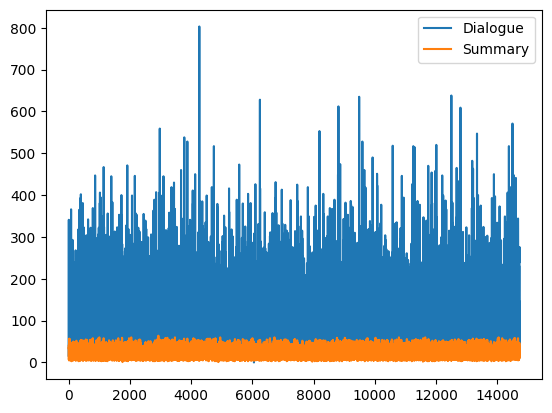

In [ ]:
# Get the lengths of the dialogue and summary tokens.
dialogue_lengths = []
summary_lengths = []

for dialogue in dataset_samsum['train']['dialogue']:
  dialogue_tokens = dialogue.split()
  dialogue_lengths.append(len(dialogue_tokens))

for summary in dataset_samsum['train']['summary']:
  summary_tokens = summary.split()
  summary_lengths.append(len(summary_tokens))

# Plot the lengths of the dialogue and summary tokens.
plt.plot(dialogue_lengths, label='Dialogue')
plt.plot(summary_lengths, label='Summary')
plt.legend()
plt.show()


In [ ]:
dialogue_lengths = pd.Series(dialogue_lengths)
summary_lengths = pd.Series(summary_lengths)
print(dialogue_lengths.describe())
print(summary_lengths.describe())

count    14732.000000
mean        93.786383
std         74.033457
min          0.000000
25%         39.000000
50%         73.000000
75%        128.000000
max        803.000000
dtype: float64
count    14732.000000
mean        20.317472
std         11.153815
min          1.000000
25%         12.000000
50%         18.000000
75%         27.000000
max         64.000000
dtype: float64


Tokenization:

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 250, truncation = True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 64, truncation = True)

    # input_encodings["target_encodings"] = target_encodings["input_ids"]
    # return input_encodings

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched = True,
                                       remove_columns = ["dialogue", "summary"]
                                       )

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
dataset_samsum_pt['train'][0]

{'input_ids': [12195,
  151,
  125,
  7091,
  3659,
  107,
  842,
  119,
  245,
  181,
  152,
  10508,
  151,
  7435,
  147,
  12195,
  151,
  125,
  131,
  267,
  650,
  119,
  3469,
  29344,
  1],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [12195, 7091, 3659, 111, 138, 650, 10508, 181, 3469, 107, 1]}

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.3 MB/s eta 0:00:00


In [ ]:
import nltk
import evaluate

In [ ]:
# Setup evaluation
nltk.download("punkt", quiet=True)
metric = evaluate.load("rouge")

In [ ]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # decode preds and labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # rougeLSum expects newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return result

In [ ]:
# Importing the DataCollatorForSeq2Seq class, for preparing and managing data for seq2seq tasks
from transformers import DataCollatorForSeq2Seq

# Creating a data collator specifically designed for sequence-to-sequence tasks using a given tokenizer and the Pegasus model.
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [ ]:
#Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# !pip cache purge
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 2.2 MB/s eta 0:00:00


In [ ]:
import accelerate
import transformers

accelerate.__version__, transformers.__version__

('0.21.0', '4.28.0')

Training Arguments:

In [ ]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
                                output_dir='freeze-pegasus-samsum2',
                                num_train_epochs=1,
                                warmup_steps=500,
                                per_device_train_batch_size=1,
                                per_device_eval_batch_size=1,
                                weight_decay=0.01,
                                logging_steps=10,
                                evaluation_strategy='steps',
                                eval_steps=500,
                                save_steps=1e6,
                                gradient_accumulation_steps=24,
                                report_to = 'wandb',
                                run_name ='freeze-dialogue-summarizer-pegasus',
                                fp16 = True
                                )

In [ ]:
trainer = Trainer(
                  model=model_pegasus,
                  args=trainer_args,
                  tokenizer=tokenizer,
                  data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"],
                  compute_metrics = compute_metrics)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


wandb: Currently logged in as: itsmeaseem22. Use `wandb login --relogin` to force relogin


You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


OutOfMemoryError: ignored

In [ ]:
## Save model
model_pegasus.save_pretrained("freeze-pegasus-samsum-model")
dir(model_pegasus)

In [ ]:
## Save tokenizer
tokenizer.save_pretrained("freeze-tokenizer")

Evaluating the fine-tuned model using the ROGUE metrics:

In [ ]:
# def generate_batch_sized_chunks(list_of_elements, batch_size):
#     for i in range(0, len(list_of_elements), batch_size):
#         yield list_of_elements[i : i + batch_size]

Function for calculating the ROGUE metrics:

In [ ]:
# def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
#                                batch_size=16, device=device,
#                                column_text="article",
#                                column_summary="highlights"):
#     article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
#     target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

#     for article_batch, target_batch in tqdm(
#         zip(article_batches, target_batches), total=len(article_batches)):

#         inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
#                         padding="max_length", return_tensors="pt")

#         summaries = model.generate(input_ids=inputs["input_ids"].to(device),
#                          attention_mask=inputs["attention_mask"].to(device),
#                          length_penalty=0.8, num_beams=8, max_length=128)
#         ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

#         # Finally, we decode the generated texts,
#         # replace the  token, and add the decoded texts with the references to the metric.
#         decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
#                                 clean_up_tokenization_spaces=True)
#                for s in summaries]

#         decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


#         metric.add_batch(predictions=decoded_summaries, references=target_batch)

#     #  Finally compute and return the ROUGE scores.
#     score = metric.compute()
#     return score

In [ ]:
# rouge_metric = load_metric('rouge')

# score = calculate_metric_on_test_ds(dataset_samsum['test'],
#                                     rouge_metric,
#                                     model_pegasus,
#                                     tokenizer,
#                                     column_text = 'dialogue',
#                                     column_summary='summary',
#                                     batch_size=8)

In [ ]:
# rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
# rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

# pd.DataFrame(rouge_dict, index = ['pegasus'])

Now Testing model:

In [ ]:
dataset_samsum = load_dataset("samsum")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("freeze-tokenizer")

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("freeze-pegasus-samsum-model")

In [ ]:
sample_text = dataset_samsum["test"][0]["dialogue"]

reference = dataset_samsum["test"][0]["summary"]

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model=model, tokenizer=tokenizer)

In [ ]:
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

In [ ]:
pwd

In [ ]:
#Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks

In [ ]:
ls

In [ ]:
import torch

In [ ]:
!pip install transformers==4.28.0

In [ ]:
!pip install huggingface_hub

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained ("pegasus-samsum-model")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
model.push_to_hub("aseemlimbu13/pegasus_dialogue_summarizer")

In [ ]:
tokenizer.push_to_hub("aseemlimbu13/pegasus_dialogue_summarizer_tokenizer")